Hotdog or Not HotDog

In [49]:
import tensorflow as tf
import numpy as np
import os
import pandas as pd
import pathlib

from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing import image_dataset_from_directory

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential

from tensorflow.keras.applications.resnet50 import preprocess_input


import matplotlib.pyplot as plt
from PIL import Image

In [2]:
# from google.colab import files
# _ = files.upload()
from google.colab import files, drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! ls /content/drive/MyDrive/Colab/DSI/NN-Hackathon/hotdog-nothotdog

test  train


In [4]:
BATCH_SIZE = 32
IMG_SIZE = (256, 256)

In [5]:
PATH = '/content/drive/MyDrive/Colab/DSI/NN-Hackathon/hotdog-nothotdog'
train_dir = os.path.join(PATH, 'train')
test_dir = os.path.join(PATH, 'test')

In [6]:
train_dataset = image_dataset_from_directory(
    train_dir,
    shuffle=True,
    validation_split=0.2,
    subset="training",
    seed=42,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
)

Found 3000 files belonging to 2 classes.
Using 2400 files for training.


In [7]:
test_dataset = image_dataset_from_directory(
    test_dir,
    shuffle=True,
    validation_split=0.2,
    subset="training",
    seed=42,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
)

Found 644 files belonging to 2 classes.
Using 516 files for training.


In [11]:
train_class_names = train_dataset.class_names

In [12]:
train_class_names

['hotdog', 'nothotdog']

In [13]:
test_class_names = test_dataset.class_names

In [14]:
test_class_names

['hotdog', 'nothotdog']

In [16]:
validation_dataset = image_dataset_from_directory(
    train_dir,
    shuffle=True,
    validation_split=0.2,
    subset="validation",
    seed=42,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
)

Found 3000 files belonging to 2 classes.
Using 600 files for validation.


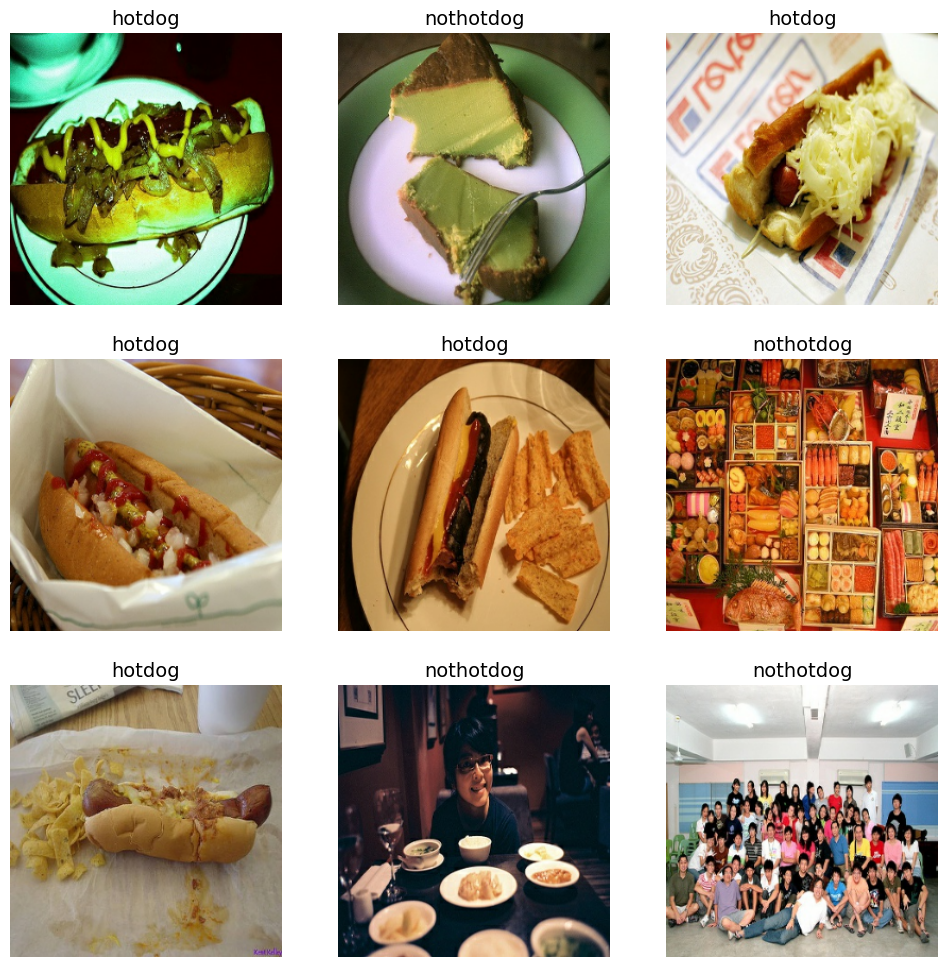

In [17]:
plt.figure(figsize=(12, 12), dpi=100)
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train_class_names[labels[i]], fontsize=14, color='black')
        plt.axis("off")
        ax.set_frame_on(False)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.subplots_adjust(wspace=0.2)

plt.show()

In [18]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [19]:
data_augmentation = tf.keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.3)
])

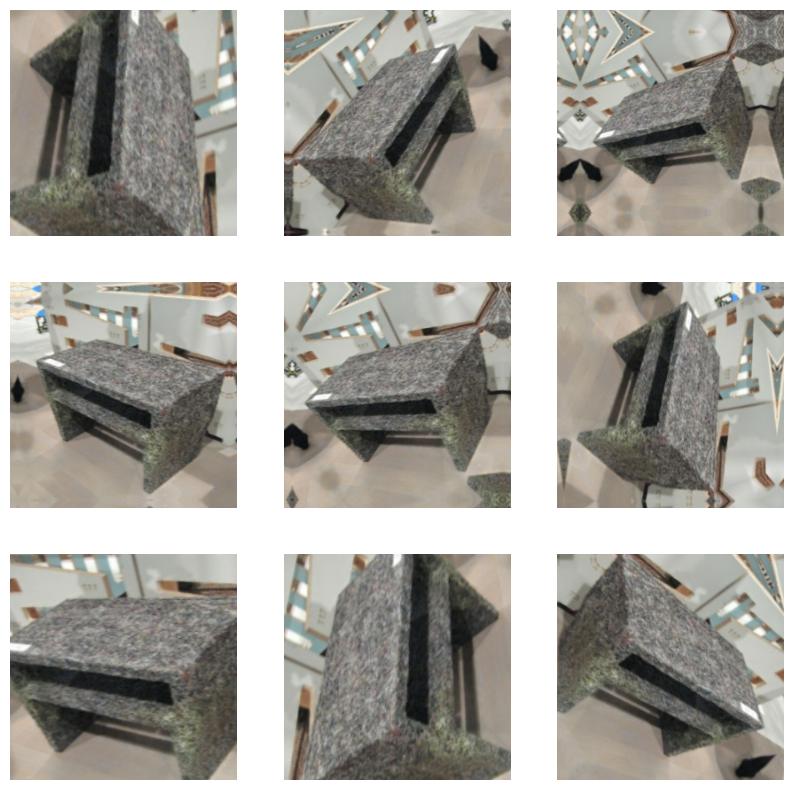

In [21]:
for images, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(images)
        plt.imshow(augmented_image[0].numpy().astype("uint8"))
        plt.axis('off')

In [27]:
rescale = tf.keras.layers.Rescaling(1./255)

In [28]:
def AlexNet():
    inputs = tf.keras.Input(shape=(256, 256, 3), name='image')
    x = data_augmentation(inputs)
    x = rescale(x)

    # Convolutional layers
    x = layers.Conv2D(96, (11, 11), strides=4, activation='relu')(x)
    x = layers.MaxPool2D((3, 3), strides=2)(x)
    x = layers.Conv2D(256, (5, 5), strides=1, padding='same', activation='relu')(x)
    x = layers.MaxPool2D((3, 3), strides=2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(384, (3, 3), strides=1, padding='same', activation='relu')(x)
    x = layers.Conv2D(384, (3, 3), strides=1, padding='same', activation='relu')(x)
    x = layers.Conv2D(256, (3, 3), strides=1, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D((3, 3), strides=2)(x)

    # Fully connected layers
    x = layers.Flatten()(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    # Output layer
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs, outputs, name='AlexNet')
    return model

model_alexnet = AlexNet()

# Display the model summary
model_alexnet.summary()


Model: "AlexNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 62, 62, 96)        34944     
                                                                 
 max_pooling2d (MaxPooling2  (None, 30, 30, 96)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 256)       614656    
                                                           

In [29]:
# Define the optimizer, loss, and metrics
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0003)
loss = tf.keras.losses.BinaryCrossentropy()
metrics = ['accuracy']

In [32]:
# Compile the model
model_alexnet.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# Define early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Train the model
epochs = 10
history_alexnet = model_alexnet.fit(train_dataset, epochs=epochs, validation_data=validation_dataset, callbacks=[early_stopping])

Epoch 1/10
75/75 [==============================] - 12s 136ms/step - loss: 1.0970 - accuracy: 0.5254 - val_loss: 1.8647 - val_accuracy: 0.4900
Epoch 2/10
75/75 [==============================] - 9s 114ms/step - loss: 0.7936 - accuracy: 0.5825 - val_loss: 1.1870 - val_accuracy: 0.4667
Epoch 3/10
75/75 [==============================] - 11s 128ms/step - loss: 0.7142 - accuracy: 0.6233 - val_loss: 1.1776 - val_accuracy: 0.5017
Epoch 4/10
75/75 [==============================] - 10s 131ms/step - loss: 0.6711 - accuracy: 0.6417 - val_loss: 0.7611 - val_accuracy: 0.6067
Epoch 5/10
75/75 [==============================] - 13s 162ms/step - loss: 0.6251 - accuracy: 0.6783 - val_loss: 0.6770 - val_accuracy: 0.6733
Epoch 6/10
75/75 [==============================] - 10s 123ms/step - loss: 0.5884 - accuracy: 0.7004 - val_loss: 1.0636 - val_accuracy: 0.5133
Epoch 7/10
75/75 [==============================] - 10s 128ms/step - loss: 0.5963 - accuracy: 0.7017 - val_loss: 1.1664 - val_accuracy: 0.5100


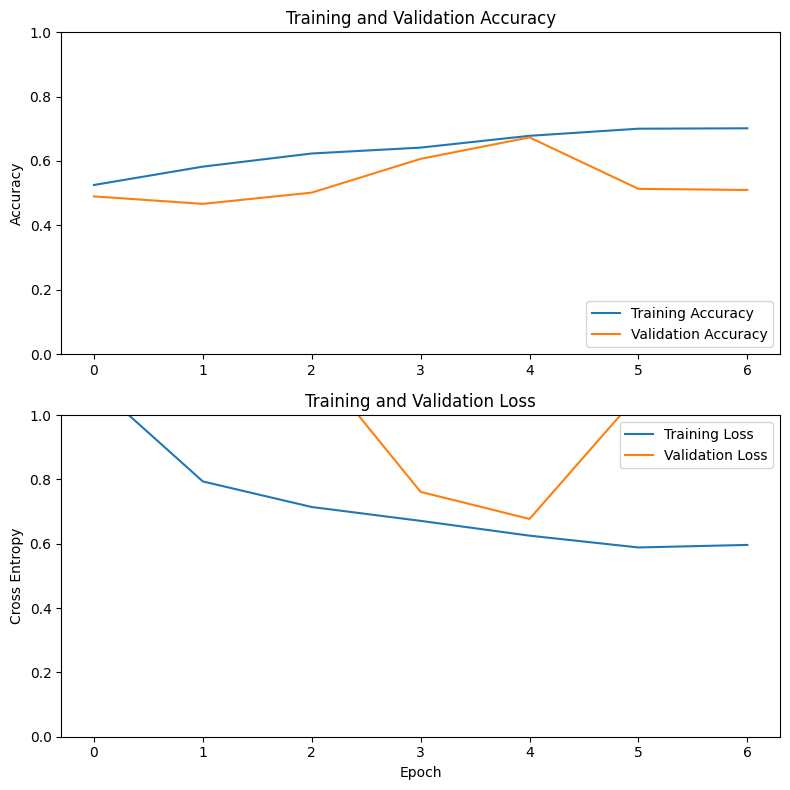

In [33]:
def plot_learning_curve(history):
    plt.figure(figsize=(8, 8))

    # Plot Training and Validation Accuracy
    plt.subplot(2, 1, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.setp(plt.gca(), ylim=[0, 1], title='Training and Validation Accuracy', ylabel='Accuracy')

    # Plot Training and Validation Loss
    plt.subplot(2, 1, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend(loc='upper right')
    plt.setp(plt.gca(), ylim=[0, 1], title='Training and Validation Loss', xlabel='Epoch', ylabel='Cross Entropy')

    plt.tight_layout()
    plt.show()

# Plot the learning curve
plot_learning_curve(history_alexnet)


In [34]:
model_alexnet.evaluate(test_dataset)

17/17 [==============================] - 43s 1s/step - loss: 0.7332 - accuracy: 0.6531


[0.7332392930984497, 0.6531007885932922]

Resnet 50

In [50]:
input_shape = (256, 256, 3)
base_model_resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
base_model_resnet50.trainable = False

# Rest of your code remains the same
data_augmentation = Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.3)
])

inputs = Input(shape=input_shape, name='image')
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model_resnet50(x)
x = GlobalAveragePooling2D()(x)
x = Dense(1000, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(1)(x)

model_resnet50 = Model(inputs, outputs, name='resnet50')

model_resnet50.summary()

Model: "resnet50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 256, 256, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 tf.__operators__.getitem_2  (None, 256, 256, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_2 (TFOpLamb  (None, 256, 256, 3)       0         
 da)                                                             
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0  

In [51]:
# Compile the model
model_resnet50.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Define early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Train the model
epochs = 10
history_resnet50 = model_resnet50.fit(train_dataset, epochs=epochs, validation_data=validation_dataset, callbacks=[callback])


Epoch 1/10
75/75 [==============================] - 25s 225ms/step - loss: 0.3924 - accuracy: 0.8404 - val_loss: 0.1600 - val_accuracy: 0.9233
Epoch 2/10
75/75 [==============================] - 14s 176ms/step - loss: 0.1981 - accuracy: 0.9200 - val_loss: 0.1429 - val_accuracy: 0.9433
Epoch 3/10
75/75 [==============================] - 14s 183ms/step - loss: 0.1875 - accuracy: 0.9283 - val_loss: 0.2222 - val_accuracy: 0.9317
Epoch 4/10
75/75 [==============================] - 14s 178ms/step - loss: 0.1873 - accuracy: 0.9229 - val_loss: 0.1504 - val_accuracy: 0.9433


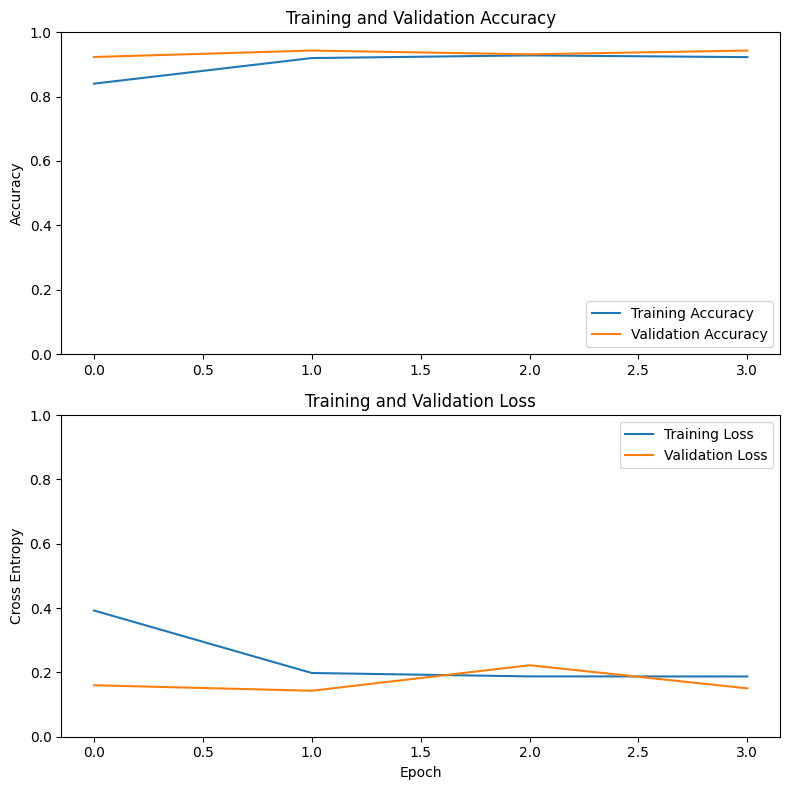

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


17/17 [==============================] - 3s 158ms/step - loss: 0.1400 - accuracy: 0.9477


[0.14001525938510895, 0.9476743936538696]

In [52]:
# Plot the learning curve
plot_learning_curve(history_resnet50)

# Save the model
model_resnet50.save('model_resnet50.h5')

# Evaluate the model on the test dataset
model_resnet50.evaluate(test_dataset)

VGG-19

In [43]:
base_model_vgg19 = tf.keras.applications.vgg19.VGG19(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model_vgg19.trainable = False

# Define the input
inputs = tf.keras.Input(shape=(256, 256, 3), name='image')

# Data augmentation
x = data_augmentation(inputs)

# Preprocess input according to VGG19
x = tf.keras.applications.vgg19.preprocess_input(x)

# Base model
x = base_model_vgg19(x)

# Global average pooling and additional layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1000, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1)(x)

# Create the VGG19 model
model_vgg19 = tf.keras.Model(inputs, outputs, name='vgg19')


In [39]:
# Compile the model
model_vgg19.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Define early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Train the model
epochs = 10
history_vgg19 = model_vgg19.fit(train_dataset, epochs=epochs, validation_data=validation_dataset, callbacks=[callback])


Epoch 1/10
75/75 [==============================] - 30s 303ms/step - loss: 1.0292 - accuracy: 0.8037 - val_loss: 0.2565 - val_accuracy: 0.9167
Epoch 2/10
75/75 [==============================] - 20s 261ms/step - loss: 0.2919 - accuracy: 0.8817 - val_loss: 0.2523 - val_accuracy: 0.9050
Epoch 3/10
75/75 [==============================] - 19s 245ms/step - loss: 0.2473 - accuracy: 0.9042 - val_loss: 0.2155 - val_accuracy: 0.9217
Epoch 4/10
75/75 [==============================] - 19s 247ms/step - loss: 0.2231 - accuracy: 0.9104 - val_loss: 0.2422 - val_accuracy: 0.9183
Epoch 5/10
75/75 [==============================] - 21s 268ms/step - loss: 0.2255 - accuracy: 0.9025 - val_loss: 0.2066 - val_accuracy: 0.9267
Epoch 6/10
75/75 [==============================] - 20s 252ms/step - loss: 0.2135 - accuracy: 0.9167 - val_loss: 0.3254 - val_accuracy: 0.8717
Epoch 7/10
75/75 [==============================] - 20s 255ms/step - loss: 0.1758 - accuracy: 0.9283 - val_loss: 0.2111 - val_accuracy: 0.9183

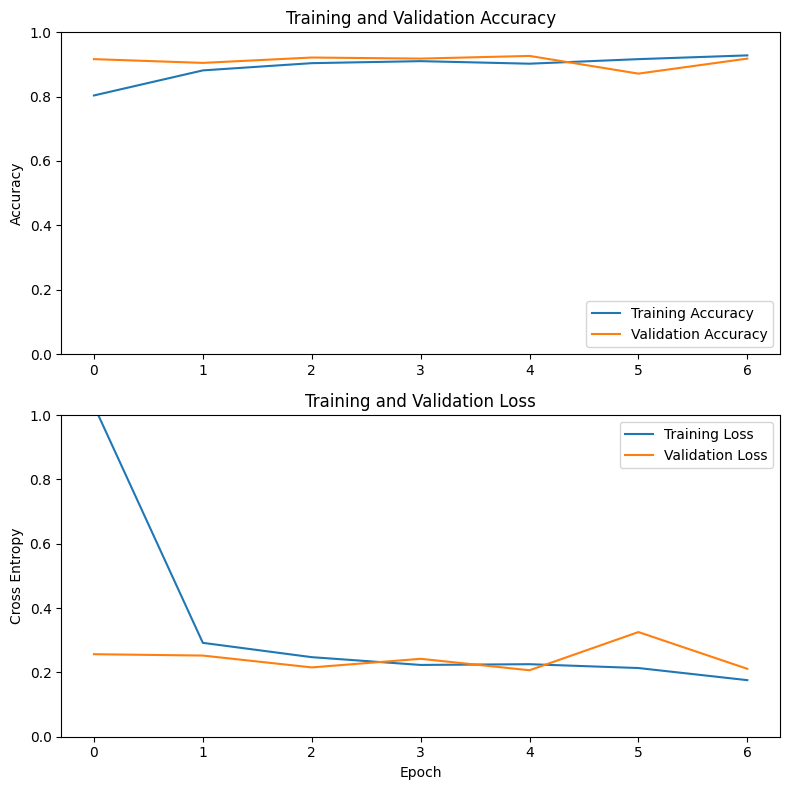

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [41]:
# Plot the learning curve
plot_learning_curve(history_vgg19)

# Save the model
model_vgg19.save('model_vgg19.h5')


In [42]:
# Evaluate the model on the test dataset
model_vgg19.evaluate(test_dataset)


17/17 [==============================] - 5s 239ms/step - loss: 0.2454 - accuracy: 0.9225


[0.24543006718158722, 0.9224806427955627]